# Experiment with nutpie mass matrix adaptation extended to normalizing flows

Nutpie finds a diagonal mass matrix by minimizing the fisher divergence of the posterior and a transformed posterior:

$$
\min_\eta \int \lVert \nabla \log N(x|0, 1) - \nabla \log \left(F^*_\eta \pi\right)(x) \rVert^2 d\left(F^*_\eta \pi\right)(x)
$$

where $F$ is a family of diffeomorphisms parametrized by $\eta$ and $\pi$ is the posterior density, and $\left(F^*_\eta \pi\right)(x) = \pi(F^{-1}_\eta(x)) \cdot \lvert\text{det}\nabla F^{-1}_\eta(x))\rvert$ is the pullback of the posterior density along the diffeomorphism. Note that the integration (and the norm) happens in the transformed space.

If $F_\eta$ is a coordinate-wise affine function $F_\eta(x) = x \odot \eta_\sigma + \eta_\mu$, we can minimize this analytically and get $\eta_\sigma^2 = \sqrt\frac{\text{Var}[X]}{\text{Var}[\nabla \log \pi(X)]}$ and $\eta_mu = \text{E}[X] + \eta_\sigma \odot \text{E}[\nabla \log \pi(X)]$.

But for some other familiy of diffeomorphisms, we can do the minimization using stochastic gradient decent.

In this notebook we use a familiy of diffeomorphisms defined by a normalizing flow implemented in flowjax.

We start sampling with some initial mass matrix.

We take some of those samples, and find a normalizing flow that transforms the posterior into something nicer, by minimizing the fisher divergence defined above.

We then sample for some time with that new transformation, to get some new draws.

After a few iterations the sampler is capable of sampling from quite difficult posteriors.

But other than with normalizing flows in VI, we still have the assurances of hmc/nuts that the samples are actually from the posterior, and diagnostics to figure out problems.

Problems I see with this so far:

- The optimization can be unreliable. If we want to put something like this into nutpie, it would have to optimizie the normalizing flow without user intervention, and often the optimization only works properly if you change for instance the learning rate or the batch size.
- I am a bit restricted in the choice of normalizing flows I can use, because the fisher divergence needs efficient forward and backward transformations. Many normalizing flow architectures don't give us that.
- It seems training the neural networks often requires quite a few draws from the posterior, definetly often more than the diagonal mass matrix adaptation. So just 1000 tuning steps might not be enough? Perhaps it might be possible to just use the full trajectories however, that would give us more training draws, and maybe even work better?


# Define model

As a test case we use a model with a 100 dimensional funnel, that also has some correlations.
Nuts based on diagonal mass matrix adaptation can not sample from this at all, as can be seen from the bad effective sample sizes.

In [70]:
import os
%env XLA_FLAGS=--xla_gpu_cuda_data_dir={os.environ['CONDA_PREFIX']}

import jax
import flowjax
import nutpie
import pymc as pm
import seaborn as sns
import flowjax.distributions
import flowjax.flows
import jax.numpy as jnp
import equinox as eqx
import flowjax.train
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz
from scipy import linalg
import dataclasses

jax.config.update("jax_enable_x64", True)

with pm.Model() as model:
    mu = pm.Normal("mu", sigma=1)
    log_sigma = pm.Normal("log_sigma", sigma=0.5)
    sigma = pt.exp(log_sigma)
    pm.Normal("b", sigma=sigma, mu=mu, shape=100)

compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")

trace = nutpie.sample(
    compiled,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    seed=123,
)

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/adr/.cache/rattler/cache/envs/flow-experiment-17471942013543406247/envs/default


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.43,15
,1300,0,0.26,15
,1300,21,0.32,7
,1300,0,0.45,15
,1300,0,0.34,7


In [71]:
def extract_points(trace):
    draws = trace.sample_stats.unconstrained_draw.stack(sample=["chain", "draw"])
    grads = trace.sample_stats.gradient.stack(sample=["chain", "draw"])
    return jnp.transpose(jnp.array([draws, grads]), [2, 0, 1]), draws.values.T, grads.values.T

points, draws, grads = extract_points(trace)

In [72]:
arviz.ess(trace).min().to_pandas()

b            66.136590
log_sigma    56.838133
mu           32.673229
dtype: float64

The effective sample sizes are very small, and the sampler clearly did not converge properly.

# Set up a normalizing flow

We set up a small normalizing flow as familiy of diffeomorphisms $F$.
We use a coupling_flow, because this one has good peroformance for both the transform and the inverse transform. We also add a affine layer with the results from the diagonal mass matrix adaptation, to nudge it into the correct region and avoid numerical trouble.

For comparison we also set up two purely affine transformations.

In [73]:
key = jax.random.PRNGKey(0)

diag = np.sqrt(draws.std(0) / grads.std(0))
mean = draws.mean(0) + diag * grads.mean(0)

diag50 = np.sqrt(draws[:50].std(0) / grads[:50].std(0))
mean50 = draws[:50].mean(0) + diag50 * grads[:50].mean(0)

flow_key, key = jax.random.split(key)
base_dist = flowjax.distributions.Normal(jnp.zeros(compiled.n_dim))
flow_templ = flowjax.flows.coupling_flow(flow_key, base_dist=base_dist, invert=True, nn_activation=jax.nn.gelu)
flow = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flow_templ.bijection,
        flowjax.flows.Affine(loc=mean50, scale=diag50),
    ]),
)

flow_diag = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flowjax.flows.Affine(loc=mean, scale=diag),
    ]),
)

flow_diag50 = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flowjax.flows.Affine(loc=mean50, scale=diag50),
    ]),
)

## Some experimental extra nn layers

The following cells contain some experimentation with an additional scaling layer in the network, they can be removed without too much difference...

In [74]:
from jax import Array
from typing import ClassVar

class MvScale(flowjax.bijections.AbstractBijection):
    """Householder transformation bijection, parameterized by a vector `params` of size n-1.
    The Householder vector is softmax(h([0, *params])), where h is a Householder transformation
    that maps the first element to the sum of the elements of the input vector.

    Args:
        params: A vector of size n-1.
    """

    shape: tuple[int, ...]
    params: jnp.ndarray
    cond_shape: ClassVar[None] = None

    def __init__(self, params: jnp.ndarray):
        """Initialize the Householder bijection with `params`."""
        super().__init__()
        n_minus_1 = params.shape[-1]
        self.shape = (n_minus_1,)
        self.params = params

    @staticmethod
    def householder_reflection(x: jnp.ndarray) -> jnp.ndarray:
        """Compute the Householder reflection that maps (1, 0, 0, ...) to (1, 1, 1, ...)/sqrt(n)."""
        n = x.shape[0]
    
        # Define the target vector: (1/sqrt(n), 1/sqrt(n), ..., 1/sqrt(n))
        target = jnp.ones(n) / jnp.sqrt(n)
    
        # Define the initial vector a = e1 = (1, 0, 0, ...)
        e1 = jnp.zeros_like(x)
        e1 = e1.at[0].set(1.0)
        
        # Compute lambda = ±||a|| = ±||e1|| = ±1. We choose the sign to maximize numerical stability
        # In our case, ||e1|| = 1, so lambda = 1
        lambda_ = jnp.sign(e1[0]) * jnp.linalg.norm(e1)  # Since ||e1|| = 1, lambda = ±1
        
        # Compute the Householder vector v = (a - lambda * target) / ||a - lambda * target||
        v = e1 - lambda_ * target
        v = -v / jnp.linalg.norm(v)
    
        # Compute the Householder reflection: Hx = x - 2 * v * (v.T @ x)
        v_dot_x = v @ x
        reflection = x - 2.0 * v * v_dot_x
        return reflection

    def scale(self, x, params):
        eig = jnp.exp(params[0])
        vec_params = params.at[0].set(0.)

        # Apply the Householder reflection directly to the extended params
        transformed_params = self.householder_reflection(vec_params)

        # Apply softmax to the transformed parameters to get the Householder vector
        vec = jnp.sqrt(jax.nn.softmax(transformed_params))
        
        # Compute the matrix-vector product using the Householder formula
        vec = vec / jnp.linalg.norm(vec)  # Ensure numerical stability
        #v_dot_x = v @ x
        #reflection = x - 2.0 * v * v_dot_x
        return vec * ((vec @ x) * (eig - 1)) + x

    def transform(self, x: jnp.ndarray, condition: Array | None = None):
        """Applies the Householder transformation (reflection) on the input."""
        # Extend params by prepending 0 to get [0, *params] in R^n
        #extended_params = jnp.concatenate([jnp.array([0.0]), self.params])
        return self.scale(x, self.params)

    def transform_and_log_det(self, x: jnp.ndarray, condition: Array | None = None):
        """The log-determinant of the Jacobian of a Householder reflection is always 0,
        since the determinant of a Householder matrix is -1."""
        return self.transform(x), self.params[0]

    def inverse(self, y, condition: Array | None = None):
        return self.scale(y, self.params.at[0].set(-self.params[0]))

    def inverse_and_log_det(self, y, condition: Array | None = None):
        return self.inverse(y), -self.params[0]

In [75]:
def transform_hh(self, x, condition=None):
    """Applies the Householder transformation (reflection) on the input."""
    # Extend params by prepending 0 to get [0, *params] in R^n
    extended_params = jnp.concatenate([jnp.array([0.0]), self.params])

    # Apply the Householder reflection directly to the extended params
    transformed_params = self.householder_reflection(extended_params)

    # Apply softmax to the transformed parameters to get the Householder vector
    v = jax.nn.softmax(transformed_params)
    
    # Compute the matrix-vector product using the Householder formula
    v = v / jnp.linalg.norm(v)  # Ensure numerical stability
    v_dot_x = v @ x
    reflection = x - 2.0 * v * v_dot_x

    return reflection

In [76]:
trafo = eqx.filter_vmap(MvScale)(jnp.zeros((8, compiled.n_dim)))

In [77]:
flow = eqx.tree_at(lambda tree: tree.bijection.bijections[0].bijection.bijection.bijections, flow, (
    *flow.bijection.bijections[0].bijection.bijection.bijections,
    trafo,
))

We set up some helper functions to transform our model and the resulting draws.

In [78]:
def normalize_model(compiled_model, flow):
    logp_fn = compiled._make_logp_func().__closure__[0].cell_contents

    @jax.jit
    def trafo_logp(x):
        def inner_logp(x):
            y, logdet = flow.bijection.transform_and_log_det(x)
            logp, _ = logp_fn(y)
            return logdet + logp

        return jax.value_and_grad(inner_logp)(x)

    def logp_wrapper(x):
        logp, grad = trafo_logp(x)
        return float(logp), np.array(grad, dtype="float64", order="C")

    return dataclasses.replace(compiled, _make_logp_func=lambda: logp_wrapper)


def unnormalize_points(trace, flow):
    normalized_draws = trace.sample_stats.unconstrained_draw.stack(sample=["chain", "draw"])
    normalized_grads = trace.sample_stats.gradient.stack(sample=["chain", "draw"])

    def get_untransformed(flow, draw_trafo, grad_trafo):
        draw = flow.bijection.transform(draw_trafo)
        _, pull_grad_fn = jax.vjp(flow.bijection.inverse_and_log_det, draw)
        (grad,) = pull_grad_fn((grad_trafo, 1.))
        return draw, grad

    get_untransformed = jax.vmap(get_untransformed, [None, 0, 0])
    
    draws, grads = get_untransformed(
        flow,
        normalized_draws.values.T,
        normalized_grads.values.T,
    )
    return jnp.transpose(jnp.array([draws, grads]), [1, 0, 2]), draws, grads

In [79]:
# The fisher divergence loss
@eqx.filter_jit
def loss(flow, draw, grad):
    trafo = flow.bijection.inverse(draw)
    _, pull_grad_fn = jax.vjp(lambda x: flow.bijection.transform_and_log_det(x), trafo)
    (grad_fit,) = pull_grad_fn((grad, 1.))

    return ((grad_fit + trafo) ** 2).sum()

In [80]:
#%timeit loss(flow, jnp.zeros(compiled.n_dim), jnp.zeros(compiled.n_dim))

In [82]:
class FisherLoss:
    @eqx.filter_jit
    def __call__(
        self,
        params,
        static,
        x,
        condition = None,
        key = None,
    ):
        flow = flowjax.train.losses.unwrap(eqx.combine(params, static))

        assert x.shape[1] == 2
        draw = x[:, 0, :]
        grad = x[:, 1, :]

        # We minimize the log of the loss. This seems to work way better,
        # I *think* because the same learning rate works for more cases.
        return jnp.log(jax.vmap(loss, [None, 0, 0])(flow, draw, grad).mean())

In [83]:
params, static = eqx.partition(flow, eqx.is_array)
float(FisherLoss()(params, static, points))

39.94271452714088

In [84]:
params, static = eqx.partition(flow_diag, eqx.is_array)
float(FisherLoss()(params, static, points))

5.283127813997333

In [85]:
params, static = eqx.partition(flow_diag50, eqx.is_array)
float(FisherLoss()(params, static, points))

6.302001897782366

# First fisher divergence minimization run

We use every second draw, and keep the other draws for validation.

In [86]:
train_key, key = jax.random.split(key)
fit, data = flowjax.train.fit_to_data(
    key=train_key,
    dist=flow,
    x=points[::2],
    batch_size=8,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
)

 70%|███████   | 141/200 [04:16<01:47,  1.82s/it, train=-1.2882485293111405, val=-0.8928839982183009 (Max patience reached)]


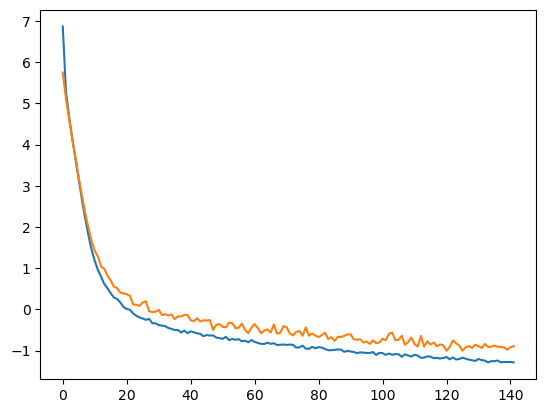

In [88]:
# with mvscale
plt.plot(np.array(data["train"]))
plt.plot(np.array(data["val"]))

In [90]:
# no mvscale
#params, static = eqx.partition(fit, eqx.is_array)
#float(FisherLoss()(params, static, points))

In [89]:
# with mvscale
params, static = eqx.partition(fit, eqx.is_array)
float(FisherLoss()(params, static, points[1::]))

-1.0835838525879362

## Some plots about the fit

We can now sample from the normal distribution on the transformed space, and
transform those draws with our learned transformation. Ideally, they look similar to the posterior.

In [92]:
sample_key, key = jax.random.split(key)
samples = fit.sample(sample_key, (6000,))

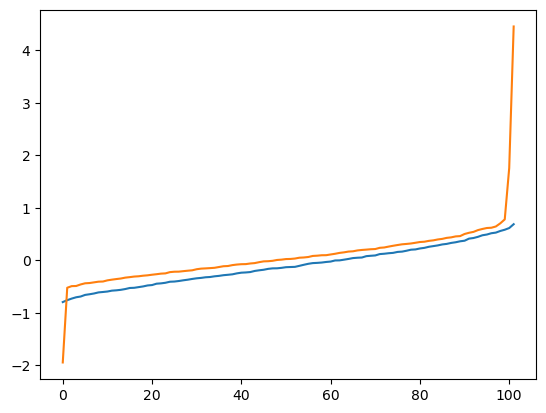

In [93]:
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.cov(samples.T))))
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.diag(diag ** 2))))

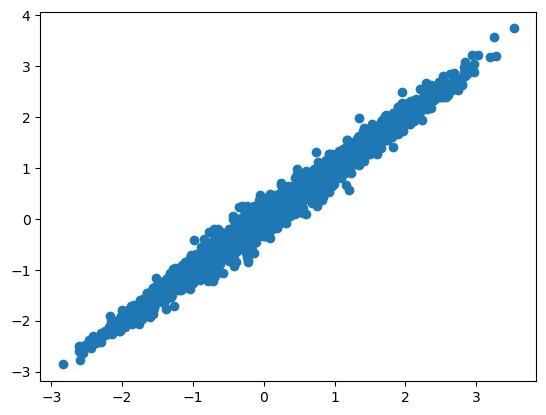

In [94]:
plt.scatter(draws[:, 0], draws[:, 2:].mean(1))

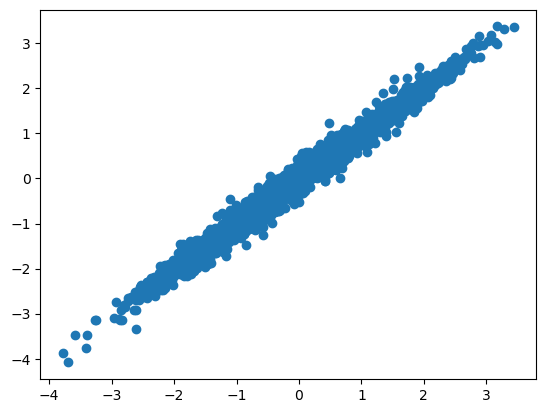

In [95]:
plt.scatter(samples[:, 0], samples[:, 2:].mean(1))

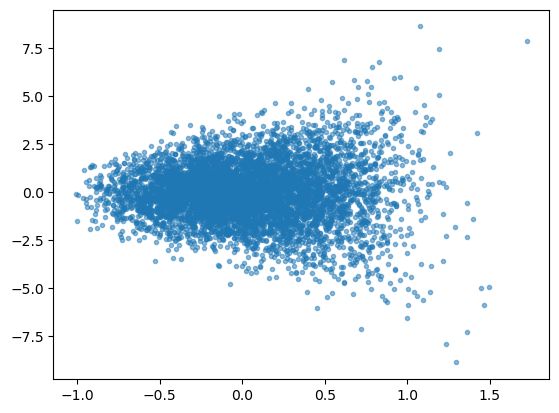

In [96]:
i = 1
j = -1
plt.scatter(samples[:, i], samples[:, j], alpha=0.5, marker=".")
#plt.scatter(draws[i], draws[j], alpha=0.5, marker=".")
#plt.xlim((-40, 40))

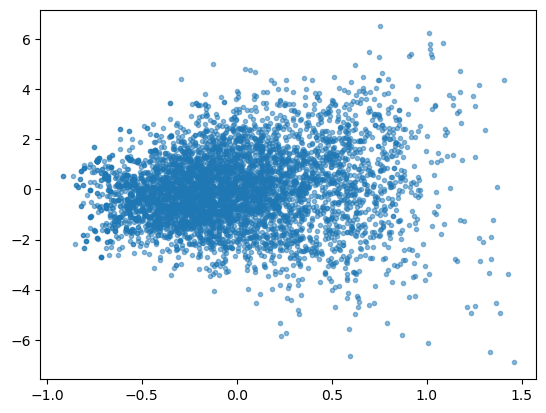

In [97]:
plt.scatter(draws[:, i], draws[:, j], alpha=0.5, marker=".")

We can also transform our (bad) posterior draws and see how well they seem to fit a standard normal distribution

In [103]:
draws_trafo = jax.vmap(fit.bijection.inverse, in_axes=[0])(draws)

In [104]:
vals, vecs = linalg.eigh(np.cov(draws_trafo.T))

In [106]:
vals

array([0.60987648, 0.62451919, 0.63229275, 0.64480721, 0.65804215,
       0.66118145, 0.66339571, 0.67611863, 0.67730751, 0.69138769,
       0.69414423, 0.7045036 , 0.70662674, 0.71351148, 0.72223965,
       0.7272195 , 0.73510915, 0.74004913, 0.7563187 , 0.758991  ,
       0.76836556, 0.77020664, 0.7801294 , 0.78281862, 0.79512837,
       0.79983162, 0.80845899, 0.81282629, 0.81722083, 0.82674042,
       0.82952921, 0.83589441, 0.84570054, 0.85317893, 0.85829959,
       0.85944991, 0.86918182, 0.879076  , 0.88969801, 0.89444373,
       0.89738597, 0.90416902, 0.90950432, 0.91117629, 0.92200063,
       0.93122178, 0.94379565, 0.94764559, 0.95806527, 0.96190658,
       0.97087231, 0.97452301, 0.98486108, 0.99561893, 1.0009418 ,
       1.00675017, 1.01641114, 1.01910832, 1.02369638, 1.03022062,
       1.03173264, 1.03589722, 1.05076713, 1.05913062, 1.06780096,
       1.08429537, 1.08819434, 1.10071005, 1.1093559 , 1.12343115,
       1.12601436, 1.13151249, 1.13882869, 1.1444773 , 1.15298

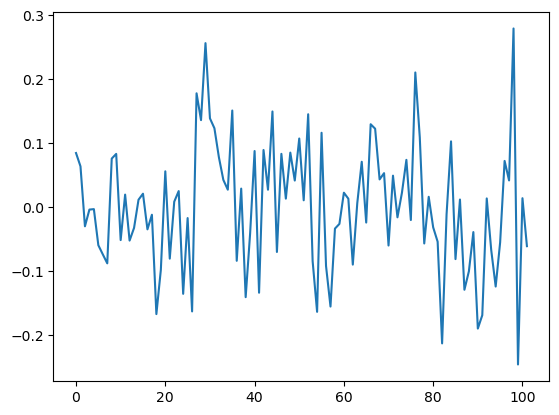

In [107]:
plt.plot(vecs[:, -1])

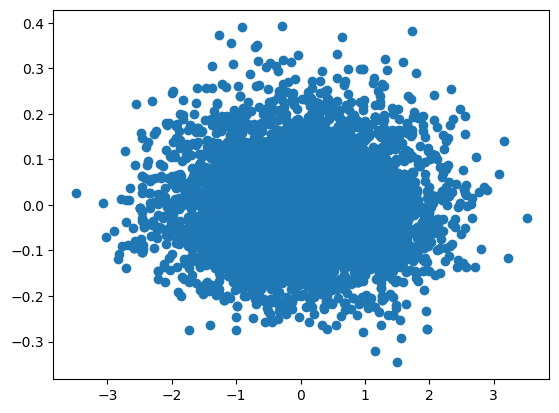

In [108]:
plt.scatter(draws_trafo[:, 0], draws_trafo[:, 1:].mean(1))

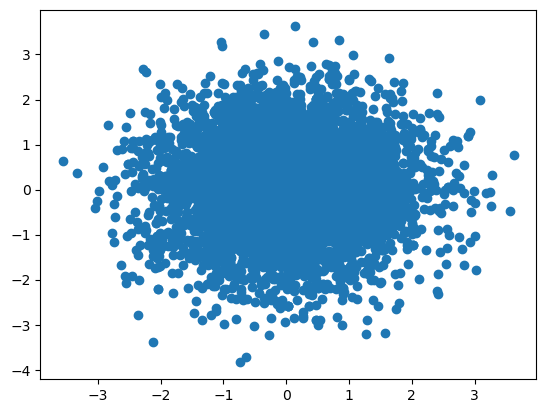

In [109]:
plt.scatter(draws_trafo[:, 1], draws_trafo[:, 10])

<Axes: ylabel='Density'>

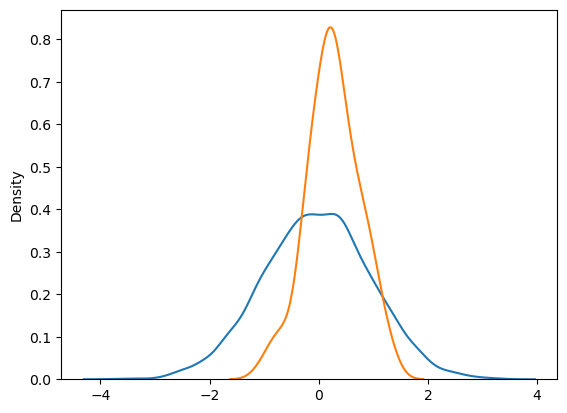

In [110]:
sns.kdeplot(samples[:, 0])
sns.kdeplot(draws[0])

# Sample again, but now in the transformed space that we just learned.

In [112]:
compiled2 = normalize_model(compiled, fit)

In [113]:
trace2 = nutpie.sample(
    compiled2,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=1234,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,1,0.51,7
,1300,0,0.50,7
,1300,0,0.52,7
,1300,0,0.54,7
,1300,0,0.51,7


In [120]:
arviz.ess(trace2).min().to_pandas()

b            1986.524084
log_sigma    8660.266843
mu           8515.339493
dtype: float64

# Repeat the fit and sample once more

The sampler is already mostly fine, but we can repeat this again to get a better fit

In [121]:
points2, draws2, grads2 = unnormalize_points(trace2, fit)

In [123]:
fit2, data = flowjax.train.fit_to_data(
    key=train_key,
    dist=fit,
    x=points2[::2],
    batch_size=8,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
)

 66%|██████▌   | 132/200 [03:56<02:01,  1.79s/it, train=-1.373366181079845, val=-1.0046895893196928 (Max patience reached)]


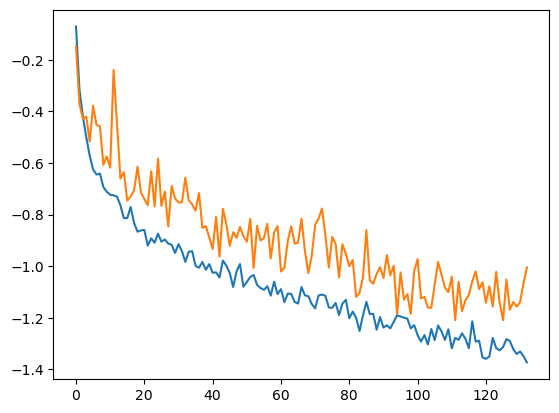

In [124]:
plt.plot(data["train"])
plt.plot(data["val"])

In [125]:
params, static = eqx.partition(fit, eqx.is_array)
FisherLoss()(params, static, points2[1::])

Array(0.70188985, dtype=float64)

In [126]:
params, static = eqx.partition(fit2, eqx.is_array)
FisherLoss()(params, static, points2[1::])

Array(-1.06874776, dtype=float64)

In [128]:
compiled3 = normalize_model(compiled, fit2)

trace3 = nutpie.sample(
    compiled3,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=123456,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,1,0.52,7
,1300,1,0.50,7
,1300,1,0.54,7
,1300,6,0.52,7
,1300,1,0.53,7


In [129]:
arviz.ess(trace3.sample_stats.unconstrained_draw).min().unconstrained_draw.values

array(4702.29491883)